In [1]:
%pylab inline
from numpy.lib.recfunctions import append_fields, drop_fields, rename_fields
from astropy.io import fits
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
x = np.genfromtxt('../input/fake_cluster/1118_real_clusters_withFeH.dat', dtype = None, names = True,
                  missing_values='""')
print(len(x),x.dtype.names)
x = append_fields(x, 'rvs', np.random.normal(0,10,len(x)), usemask=False, asrecarray=True)
x = np.sort(x,order = 'nbstars')

1118 ('clusterName', 'ra', 'dec', 'l', 'b', 'r50', 'nbstars', 'pmra', 'pmdec', 'par', 'd05', 'd16', 'dmode', 'd84', 'd95', 'Rgc', 'distance_Kharchenko', 'logt_Kharchenko', 'rc_Kharchenko', 'rt_Kharchenko', 'FeH_Kharchenko', 'FeH_synth')


/home/rybizki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


In [3]:
print(sum(x.nbstars))
# generate random mass (so that total number of stars < G18 is comparable to total number of generated stars)
mass = 300+np.abs(np.random.normal(0,500,len(x)))
print(np.mean(mass))
mass = np.sort(mass)
# Sort mass and vrot according to nbstars (more stars --> more mass --> higher vrot)
x = append_fields(x,'mass',mass,usemask=False, asrecarray=True)
# generate random speed at half light radius
vrot = np.sort(np.random.uniform(0.1,0.7,len(x)))
x = append_fields(x,'vrot',vrot,usemask=False, asrecarray=True)

200024
690.0116629068492


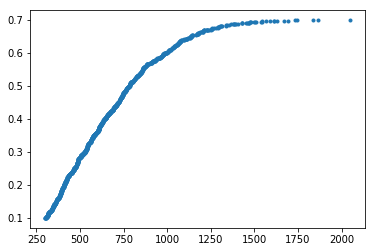

In [4]:
plt.plot(x.mass,x.vrot,'.')

In [5]:
# creating distances
distances = np.zeros(len(x))
for i in range(len(x)):
    distances[i] = x.dmode[i]
    if x.dmode[i] > 5000:
        distances[i] = x.distance_Kharchenko[i]

In [6]:
fields_to_drop = ['l', 'b', 'nbstars', 'par', 'd05', 'd16',
                  'd84', 'd95','Rgc','rc_Kharchenko',
                  'rt_Kharchenko', 'FeH_Kharchenko','distance_Kharchenko', 'dmode']

x = drop_fields(x, fields_to_drop, usemask=False, asrecarray=True)
x = append_fields(x, 'distance_pc', distances, usemask=False, asrecarray=True)

In [7]:
# reformatting ages
x.logt_Kharchenko = np.power(10,x.logt_Kharchenko)/1e9
x = rename_fields(x,{"logt_Kharchenko":"age_gyr"})
# adding noise to synthetic feh
x.FeH_synth = np.random.normal(x.FeH_synth,0.1)

In [8]:
# generate random rotation axis
# random longitude
rangle = np.random.uniform(0,2*np.pi,len(x))
# random latitude
rz = []
count = False
for i in range(3*len(x)):
    uniform = np.random.uniform(-0.5*np.pi,0.5*np.pi)
    th = np.random.sample(1)
    if th < np.cos(uniform):
        rz.append(uniform)
rz = np.array(rz)[:len(x)] + np.pi/2
# transforming to the normal spin vektor
x0 = np.sin(rz) * np.cos(rangle)
y0 = np.sin(rz) * np.sin(rangle)
z0 = np.cos(rz)
x = append_fields(x,'x0',x0,usemask=False, asrecarray=True)
x = append_fields(x,'y0',y0,usemask=False, asrecarray=True)
x = append_fields(x,'z0',z0,usemask=False, asrecarray=True)

In [9]:
print(x.r50[0])

0.121


In [10]:
# half mass radius in physical units (r50 is arcdegree)
tan = np.tan(x.r50*(np.pi/180.))
hmrad = tan * distances
x.r50 = hmrad
#hmrad = np.divide(distances,57.3) * x.r50

In [11]:
print(x.dtype.names)

('clusterName', 'ra', 'dec', 'r50', 'pmra', 'pmdec', 'age_gyr', 'FeH_synth', 'rvs', 'mass', 'vrot', 'distance_pc', 'x0', 'y0', 'z0')


In [12]:
name = '../input/fake_cluster/cluster_for_processing.fits'
os.remove(name)
fits.writeto(name,x)

In [13]:
print(x.r50[0])

3.627316195597982


In [14]:
x.age_gyr

array([0.02511886, 0.616595  , 0.06025596, ..., 0.82224265, 3.16227766,
       1.840772  ])